In [1]:
# 导入模型评估部分的代码
from utils import get_predictions, evaluate_model, print_evaluation_scores, plot_roc_curve, compute_metrics

In [2]:
import os
import numpy as np
from datasets import load_dataset, DatasetDict
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

nltk.download('punkt')
nltk.download('stopwords')

# 加载IMDB数据集
dataset = load_dataset("stanfordnlp/imdb")
dataset = DatasetDict({
    'train': dataset['train'],
    'test': dataset['test']
})

# 去除停用词和分词
stop_words = set(stopwords.words('english'))

def preprocess_text(example):
    text = re.sub(r'\W', ' ', example['text'])  # 删除标点符号
    text = re.sub(r'\d+', '', text)  # 删除数字
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return {"tokenized": tokens}

# 预处理数据集
dataset = dataset.map(preprocess_text, remove_columns=['text'])

# 划分数据集为训练集、验证集和测试集
train_test_split = dataset['train'].train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
eval_dataset = train_test_split['test']
test_dataset = dataset['test']

train_dataset, eval_dataset, test_dataset

/home/users/zsy/miniconda3/envs/dm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /home/users/zsy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/users/zsy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(Dataset({
     features: ['label', 'tokenized'],
     num_rows: 20000
 }),
 Dataset({
     features: ['label', 'tokenized'],
     num_rows: 5000
 }),
 Dataset({
     features: ['label', 'tokenized'],
     num_rows: 25000
 }))

In [ ]:
from gensim.models import KeyedVectors

def load_w2v_model():
    word2vec_path = 'GoogleNews-vectors-negative300.bin'
    if not os.path.exists(word2vec_path):
        print("Downloading pre-trained Word2Vec model...")
        import gensim.downloader as api
        model = api.load("word2vec-google-news-300")
        model.save_word2vec_format(word2vec_path, binary=True)
    else:
        model = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
    return model

w2v_model = load_w2v_model()

In [ ]:
# 创建词汇表
all_tokens = [token for text in train_dataset['tokenized'] for token in text if token in w2v_model]
vocab = set(all_tokens)
word_index = {word: idx + 2 for idx, word in enumerate(vocab) if word in w2v_model}
word_index['<PAD>'] = 0
word_index['<unknown>'] = 1
len(word_index), word_index

(46167,
 {'rumored': 2,
  'shaded': 3,
  'meerkats': 4,
  'signposting': 5,
  'french': 6,
  'sears': 7,
  'levelheaded': 8,
  'wrinkly': 9,
  'defrocked': 10,
  'schemer': 11,
  'vegetarianism': 12,
  'minx': 13,
  'pah': 14,
  'dukes': 15,
  'hardy': 16,
  'avantgarde': 17,
  'afterall': 18,
  'composes': 19,
  'canoeing': 20,
  'contactees': 21,
  'mack': 22,
  'patience': 23,
  'archaeological': 24,
  'tauted': 25,
  'pendejo': 26,
  'singe': 27,
  'undergrounds': 28,
  'policier': 29,
  'gambits': 30,
  'coma': 31,
  'linesman': 32,
  'worden': 33,
  'inherited': 34,
  'gourds': 35,
  'infections': 36,
  'inventions': 37,
  'bazookas': 38,
  'irises': 39,
  'examination': 40,
  'misdirection': 41,
  'shorten': 42,
  'aspidistra': 43,
  'gearhead': 44,
  'groin': 45,
  'naieve': 46,
  'outs': 47,
  'hissing': 48,
  'pronunciation': 49,
  'rehash': 50,
  'hoola': 51,
  'overgrown': 52,
  'motored': 53,
  'bloodsucking': 54,
  'complexes': 55,
  'tripple': 56,
  'forlornly': 57,
  'h

In [ ]:
word_index["<PAD>"], word_index["<unknown>"], word_index["good"], word_index["bad"]

(0, 1, 27853, 23421)

In [ ]:
# 创建嵌入矩阵
embedding_dim = 300
embedding_matrix = np.zeros((len(word_index) + 2, embedding_dim))


for word, idx in word_index.items():
        if idx == 0:
            # <PAD> token
            embedding_matrix[0] = np.zeros(embedding_dim)
        elif idx == 1:
            # <unknown> token
            embedding_matrix[1] = np.random.normal(size=(embedding_dim,))
        else:
            embedding_matrix[idx] = w2v_model[word]

embedding_matrix.shape

(46169, 300)

In [13]:
# 持久化词汇表和嵌入矩阵
import pickle
import os


path = 'LSTM_features/'
if not os.path.exists(path):
    os.makedirs(path)

with open(path + 'word_index.pkl', 'wb') as f:
    pickle.dump(word_index, f)

np.save(path + 'embedding_matrix.npy', embedding_matrix)

NameError: name 'word_index' is not defined

In [6]:
# 读取持久化的词汇表和嵌入矩阵
import pickle
import numpy as np


path = 'LSTM_features/'
with open(path + 'word_index.pkl', 'rb') as f:
    word_index = pickle.load(f)

embedding_matrix = np.load(path + 'embedding_matrix.npy')

In [7]:
word_index, embedding_matrix[1][:10]

({'rumored': 2,
  'shaded': 3,
  'meerkats': 4,
  'signposting': 5,
  'french': 6,
  'sears': 7,
  'levelheaded': 8,
  'wrinkly': 9,
  'defrocked': 10,
  'schemer': 11,
  'vegetarianism': 12,
  'minx': 13,
  'pah': 14,
  'dukes': 15,
  'hardy': 16,
  'avantgarde': 17,
  'afterall': 18,
  'composes': 19,
  'canoeing': 20,
  'contactees': 21,
  'mack': 22,
  'patience': 23,
  'archaeological': 24,
  'tauted': 25,
  'pendejo': 26,
  'singe': 27,
  'undergrounds': 28,
  'policier': 29,
  'gambits': 30,
  'coma': 31,
  'linesman': 32,
  'worden': 33,
  'inherited': 34,
  'gourds': 35,
  'infections': 36,
  'inventions': 37,
  'bazookas': 38,
  'irises': 39,
  'examination': 40,
  'misdirection': 41,
  'shorten': 42,
  'aspidistra': 43,
  'gearhead': 44,
  'groin': 45,
  'naieve': 46,
  'outs': 47,
  'hissing': 48,
  'pronunciation': 49,
  'rehash': 50,
  'hoola': 51,
  'overgrown': 52,
  'motored': 53,
  'bloodsucking': 54,
  'complexes': 55,
  'tripple': 56,
  'forlornly': 57,
  'hoochie':

Train dataset length: mean=123.61, std=93.58
Eval dataset length: mean=123.32, std=94.07
Test dataset length: mean=120.72, std=91.28


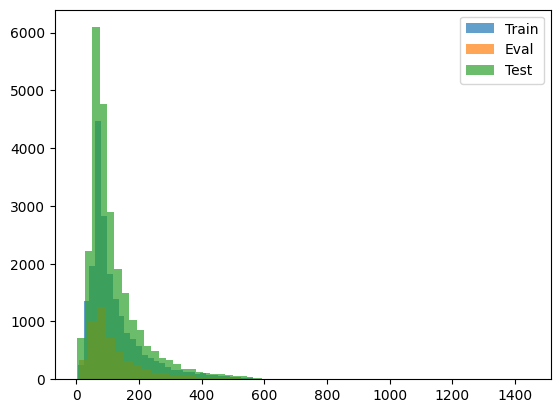

In [8]:
def get_tokenized_length(tokenized):
    return len(tokenized)

def get_mean_and_std(lengths):
    return np.mean(lengths), np.std(lengths)

train_dataset_length = [get_tokenized_length(text) for text in train_dataset['tokenized']]
eval_dataset_length = [get_tokenized_length(text) for text in eval_dataset['tokenized']]
test_dataset_length = [get_tokenized_length(text) for text in test_dataset['tokenized']]

print("Train dataset length: mean={:.2f}, std={:.2f}".format(*get_mean_and_std(train_dataset_length)))
print("Eval dataset length: mean={:.2f}, std={:.2f}".format(*get_mean_and_std(eval_dataset_length)))
print("Test dataset length: mean={:.2f}, std={:.2f}".format(*get_mean_and_std(test_dataset_length)))

from matplotlib import pyplot as plt
plt.hist(train_dataset_length, bins=50, alpha=0.7, label='Train')
plt.hist(eval_dataset_length, bins=50, alpha=0.7, label='Eval')
plt.hist(test_dataset_length, bins=50, alpha=0.7, label='Test')
plt.legend()
plt.show()

选择一个合适的序列长度，使得大部分数据都可以被覆盖。由于99分位数是476，因此我们可以选择这个作为填充的最大长度。这个长度会包含大多数数据，同时不至于过长。

In [9]:
def get_99_quantile_length(lengths):
    # 返回列表的99分位数
    return np.percentile(lengths, 99)

mean_99_quantile_length = np.mean([get_99_quantile_length(train_dataset_length),
                                    get_99_quantile_length(eval_dataset_length),
                                    get_99_quantile_length(test_dataset_length)])
mean_99_quantile_length.round()

479.0

In [10]:
# 将文本转换为序列
def text_to_sequence(text):
    sequence = [word_index.get(word, 1) for word in text]  # 1 是 <unknown> token
    return sequence

# 填充序列
def pad_sequences(sequences, max_length=476):
    padding_sequences = np.zeros((len(sequences), max_length))
    for i, seq in enumerate(sequences):
        if len(seq) >= max_length:
            padding_sequences[i] = seq[:max_length]
        else:
            padding_sequences[i][-len(seq):] = seq
    return padding_sequences

In [11]:
# test
sequences = [
    [1, 2, 3],
    [4, 5],
    [6],
    [1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1]
]
pad_sequences(sequences, 5)

array([[0., 0., 1., 2., 3.],
       [0., 0., 0., 4., 5.],
       [0., 0., 0., 0., 6.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [12]:
X_train = pad_sequences([text_to_sequence(text) for text in train_dataset['tokenized']])
X_eval = pad_sequences([text_to_sequence(text) for text in eval_dataset['tokenized']])
X_test = pad_sequences([text_to_sequence(text) for text in test_dataset['tokenized']])

y_train = np.array(train_dataset['label'])
y_eval = np.array(eval_dataset['label'])
y_test = np.array(test_dataset['label'])

print(f"训练集形状: {X_train.shape}")
print(f"验证集形状: {X_eval.shape}")
print(f"测试集形状: {X_test.shape}")

训练集形状: (20000, 476)
验证集形状: (5000, 476)
测试集形状: (25000, 476)


# 深度学习方法

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, Dataset

In [14]:
# 设置随机种子
torch.manual_seed(42)

In [15]:
class IMDBDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.texts[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.float)

train_dataset = IMDBDataset(X_train, y_train)
eval_dataset = IMDBDataset(X_eval, y_eval)
test_dataset = IMDBDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [16]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, embedding_matrix, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        # self.embedding.weight.requires_grad = False  # 禁止更新预训练的词向量
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        # 可训练参数量
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f"可训练参数量: {trainable_params}")

    def forward(self, text):
        embedded = self.embedding(text)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
        return self.fc(hidden)

In [17]:
def train_model(model, train_loader, eval_loader, optimizer, criterion, device, epochs=10):
    best_epoch = 0
    best_eval_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            predictions = model(texts).squeeze(1)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader)}')

        model.eval()
        eval_loss = 0
        corrects = 0
        with torch.no_grad():
            for texts, labels in eval_loader:
                texts, labels = texts.to(device), labels.to(device)
                predictions = model(texts).squeeze(1)
                loss = criterion(predictions, labels)
                eval_loss += loss.item()
                preds = torch.round(torch.sigmoid(predictions))
                corrects += torch.sum(preds == labels).item()
        eval_accuracy = corrects / len(eval_loader.dataset)
        print(f'Epoch {epoch+1}, Eval Loss: {eval_loss/len(eval_loader)}, Eval Accuracy: {eval_accuracy}')
        
        if epoch == 0 or eval_loss < best_eval_loss:
            best_epoch = epoch
            best_eval_loss = eval_loss
            torch.save(model.state_dict(), 'lstm_best_model.pth')
    
    print(f'Best Eval Loss: {best_eval_loss/len(eval_loader)}')
    print(f'Best Epoch: {best_epoch}')
    return best_epoch, best_eval_loss

In [39]:
def test_model(model, test_loader, criterion, device):
    model.load_state_dict(torch.load('lstm_best_model.pth'))
    model.eval()
    test_loss = 0
    corrects = 0
    preds_list = []
    predict_score = []
    labels_list = []
    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)
            predictions = model(texts).squeeze(1)
            loss = criterion(predictions, labels)
            test_loss += loss.item()
            preds_score = torch.sigmoid(predictions)
            preds = torch.round(preds_score)
            corrects += torch.sum(preds == labels).item()
            preds_list.extend(preds.cpu().numpy())
            predict_score.extend(preds_score.cpu().numpy())
            labels_list.extend(labels.cpu().numpy())
    
    print_evaluation_scores("LSTM", labels_list, preds_list)
    plot_roc_curve("LSTM", labels_list, predict_score)

In [40]:
from sklearn.model_selection import ParameterGrid

def grid_search(train_loader, eval_loader, test_loader, embedding_matrix, param_grid, device):
    best_params = None
    best_eval_loss = float('inf')
    
    for params in ParameterGrid(param_grid):
        print(f"Training with parameters: {params}")
        model = LSTMModel(
            vocab_size=len(embedding_matrix),
            embedding_dim=300,
            embedding_matrix=embedding_matrix,
            hidden_dim=params['hidden_dim'],
            bidirectional=params['bidirectional'],
            output_dim=1,
            n_layers=params['n_layers'],
            dropout=params['dropout']
        ).to(device)
        
        criterion = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
        
        best_epoch, eval_loss = train_model(model, train_loader, eval_loader, optimizer, criterion, device, epochs=params['epochs'])
        
        if eval_loss < best_eval_loss:
            best_eval_loss = eval_loss
            best_params = params
            
    print(f"Best parameters: {best_params}")
    print(f"Best Eval Loss: {best_eval_loss}")

    # 使用最佳参数重新训练模型，并在测试集上评估
    best_model = LSTMModel(
        vocab_size=len(embedding_matrix),
        embedding_dim=300,
        embedding_matrix=embedding_matrix,
        hidden_dim=best_params['hidden_dim'],
        output_dim=1,
        n_layers=best_params['n_layers'],
        bidirectional=best_params['bidirectional'],
        dropout=best_params['dropout']
    ).to(device)
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])
    
    train_model(best_model, train_loader, eval_loader, optimizer, criterion, device, epochs=best_params['epochs'])
    test_model(best_model, test_loader, criterion, device)

Training with parameters: {'bidirectional': True, 'dropout': 0.7, 'epochs': 5, 'hidden_dim': 256, 'learning_rate': 0.0001, 'n_layers': 2}
可训练参数量: 16570957
Epoch 1, Loss: 0.641423465909472
Epoch 1, Eval Loss: 0.4138337835669518, Eval Accuracy: 0.8268
Epoch 2, Loss: 0.36630394874484673
Epoch 2, Eval Loss: 0.33576293773949145, Eval Accuracy: 0.858
Epoch 3, Loss: 0.2895055637238132
Epoch 3, Eval Loss: 0.3220094036310911, Eval Accuracy: 0.8696
Epoch 4, Loss: 0.24181527364405858
Epoch 4, Eval Loss: 0.32420229353010654, Eval Accuracy: 0.8722
Epoch 5, Loss: 0.2038594519921169
Epoch 5, Eval Loss: 0.2856476683169603, Eval Accuracy: 0.8858
Best Eval Loss: 0.2856476683169603
Best Epoch: 4
Best parameters: {'bidirectional': True, 'dropout': 0.7, 'epochs': 5, 'hidden_dim': 256, 'learning_rate': 0.0001, 'n_layers': 2}
Best Eval Loss: 11.425906732678413
可训练参数量: 16570957
Epoch 1, Loss: 0.6519566163135941
Epoch 1, Eval Loss: 0.45289544463157655, Eval Accuracy: 0.8042
Epoch 2, Loss: 0.3801500349287774
Ep

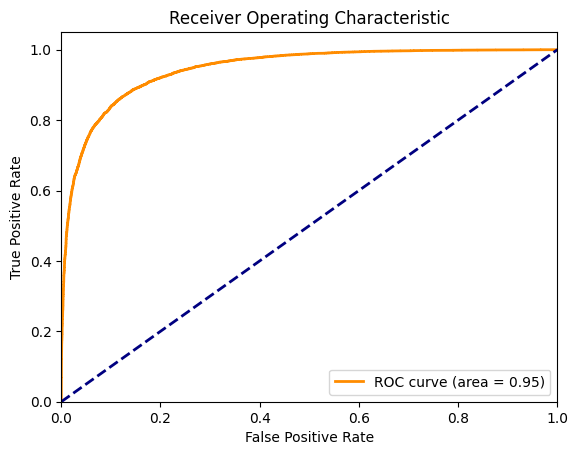

In [41]:
param_grid = {
    'hidden_dim': [256],
    'n_layers': [2],
    'bidirectional': [True],
    'dropout': [0.7],
    'learning_rate': [0.0001],
    'epochs': [5]
}

device = torch.device('cuda')
grid_search(train_loader, eval_loader, test_loader, embedding_matrix, param_grid, device)

In [ ]:
model.eval()
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
preds_list = []
predict_score = []
labels_list = []
for texts, labels in test_loader:
    texts, labels = texts.to(device), labels.to(device)
    predictions = model(texts).squeeze(1)
    predict_score = torch.sigmoid(predictions)
    preds = torch.round(predict_score)
    preds_list.extend(preds.cpu().numpy())
    predict_score.extend(predict_score.cpu().numpy())
    labels_list.extend(labels.cpu().numpy())

In [ ]:
print_evaluation_scores("LSTM", labels_list, preds_list)
plot_roc_curve("LSTM", labels_list. predict_score)